In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
train_num=len(os.listdir(r'Task1/train/no'))
val_num=len(os.listdir(r'Task1/val/no'))
image_size= np.load(r'Task1/train/no/1.npy').shape[1]
print("train_num",train_num,"image_size",image_size)
print("val_num",val_num,"image_size",image_size)

train_num 10000 image_size 150
val_num 2500 image_size 150


In [33]:


#labels: 0:no 1:sphere 2:vort
x_train=np.empty((3*train_num,1,image_size,image_size))
y_train=np.empty(3*train_num)
x_val=np.empty((3*val_num,1,image_size,image_size))
y_val=np.empty(3*val_num)
for i in range(train_num):
    x_train[i,0]=np.load(r'Task1/train/no/'+str(i+1)+'.npy')
    y_train[i]=0
for i in range(train_num):
    x_train[train_num+i,0]=np.load(r'Task1/train/sphere/'+str(i+1)+'.npy')
    y_train[train_num+i]=1
for i in range(train_num):
    x_train[2*train_num+i,0]=np.load(r'Task1/train/vort/'+str(i+1)+'.npy')
    y_train[2*train_num+i]=2

for i in range(val_num):
    x_val[i,0]=np.load(r'Task1/val/no/'+str(i+1)+'.npy')
    y_val[i]=0
for i in range(val_num):
    x_val[val_num+i,0]=np.load(r'Task1/val/sphere/'+str(i+1)+'.npy')
    y_val[val_num+i]=1
for i in range(val_num):
    x_val[2*val_num+i,0]=np.load(r'Task1/val/vort/'+str(i+1)+'.npy')
    y_val[2*val_num+i]=2

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


(27000, 1, 150, 150) (27000,)


train_num 27000 test_num 3000 val_num 2500


(array([ 995., 1017.,  988.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

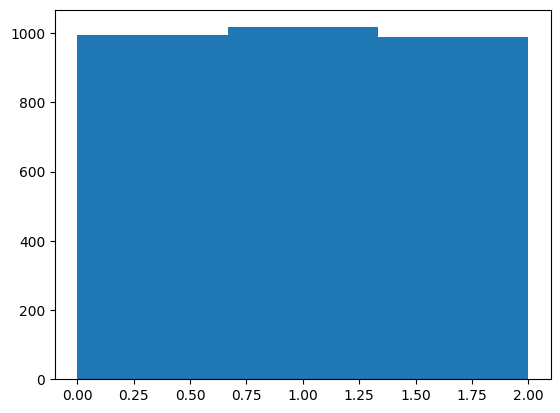

In [57]:
train_num=x_train.shape[0]
test_num=x_test.shape[0]
print("train_num",train_num,"test_num",test_num,"val_num",val_num)
bin,hist=np.histogram(y_test)
plt.hist(y_test,bins=3)

In [58]:
np.save('Task1/x_train.npy', x_train)
np.save('Task1/y_train.npy', y_train)
np.save('Task1/x_val.npy', x_val)
np.save('Task1/y_val.npy', y_val)
np.save('Task1/x_test.npy', x_test)
np.save('Task1/y_test.npy', y_test)

In [60]:
from torchvision import transforms
import random
resized_image=64
train_transform = transforms.Compose([transforms.Resize(resized_image),
                                      transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          ])
val_transform = transforms.Compose([transforms.Resize(resized_image)])
test_transform = transforms.Compose([transforms.Resize(resized_image)])

In [61]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
batch_size = 64
class NumpyDataset(Dataset):
    def __init__(self, data_path, labels_path, transform, three_channels=False):
        self.data = np.load(data_path, mmap_mode='r')
        self.labels = np.load(labels_path, mmap_mode='r')
        self.transform = transform
        self.three_channels = three_channels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = data.astype(np.float32)
        data = self.transform(torch.from_numpy(data))
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return data, label

def get_dataloader(data_path, labels_path, augmentations, batch_size=100,shuffle=True):

    # create dataset
    dataset = NumpyDataset(data_path, labels_path, augmentations)
    # create dataloader
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)
    
    return dataloader
train_dataloader = get_dataloader('Task1/x_train.npy', 'Task1/y_train.npy', train_transform, batch_size=batch_size)
val_dataloader = get_dataloader('Task1/x_val.npy', 'Task1/y_val.npy', val_transform, batch_size=batch_size)
test_dataloader = get_dataloader('Task1/x_test.npy', 'Task1/y_test.npy', test_transform)

In [45]:
print(train_dataloader.dataset.data.shape)

(30000, 1, 150, 150)


In [46]:
from torchsummary import summary
from torch import nn
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device) 
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self,three_channel=3,image_size=64,num_classes=10):
        super(ResNet18, self).__init__()
        self.size=resized_image
        self.conv1 = nn.Conv2d(three_channel, image_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(image_size)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, resized_image, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 2*resized_image, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 4*resized_image, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 8*resized_image, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(8*resized_image, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.size, out_channels, stride))
            self.size = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
model=ResNet18(1,resized_image,3).to(device)
summary(model,(1,resized_image,resized_image))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             576
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1

In [40]:
hyperparams = {'learning_rate': 1e-3,
                'weight_decay': 5e-5,
                'cyclic_scheduler': True
            }

In [62]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
def train(model, dataloader, dataloader_test, epochs, hyperparams, save_path):
    criterion = nn.CrossEntropyLoss()
    lr = hyperparams['learning_rate']
    wd = hyperparams['weight_decay']
    cyclic_scheduler = hyperparams['cyclic_scheduler']

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    if cyclic_scheduler:
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(dataloader))

    # early stopping variables
    start_epoch = 0
    best_acc = 0.0
    patience = 15
    bad_epochs = 0

    # metrics
    history = {'loss': [], 'accuracy': []}

    # training loop
    for epoch in range(start_epoch, epochs):
        running_loss = 0.0
        for data, labels in tqdm(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            # zero gradients
            optimizer.zero_grad()
            #print(data[:,None,:,:].shape)
            #print(labels.shape) 
            # classify and get loss
            outputs = model(data) 
            loss = criterion(outputs, labels)
            
            # backpropagate and update weights
            loss.backward()
            optimizer.step()

            if cyclic_scheduler:
                scheduler.step()

            # metrics
            running_loss += loss.item()

        # get losses
        epoch_loss = running_loss / len(dataloader)
        history['loss'].append(epoch_loss)

        #epoch_accuracy = evaluate(model,dataloader)
        val_epoch_accuracy =evaluate(model,dataloader_test)
        history['accuracy'].append(val_epoch_accuracy)
        
        # save checkpoint
        if val_epoch_accuracy > best_acc:
            torch.save(model.state_dict(), save_path)
            best_acc = val_epoch_accuracy
            bad_epochs = 0
            
        else:
            bad_epochs += 1
        
        print('[Epoch {}/{}] loss: {:.6f}; val accuracy: {:.6f};'.format(epoch+1, epochs, epoch_loss,  val_epoch_accuracy))
        
        if bad_epochs >= patience:
            print(f"reached {bad_epochs} bad epochs, stopping training with best val accuracy of {best_acc}!")
            break

    best = torch.load(save_path)
    model.load_state_dict(best)
    
    return history

def evaluate(model, dataloader, return_lists_roc=False):
    labels_list = []
    outputs_list = []
    preds_list = []

    with torch.no_grad():
        for data, labels in tqdm(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            # predict
            outputs = F.softmax(model(data), dim=1)

            # numpify
            labels_numpy = labels.detach().cpu().numpy()
            outputs_numpy = outputs.detach().cpu().numpy() # probs (AUROC)
            
            preds = np.argmax(outputs_numpy, axis=1) # accuracy

            # append
            labels_list.append(labels_numpy)
            outputs_list.append(outputs_numpy)
            preds_list.append(preds)

        labels_list = np.concatenate(labels_list)
        outputs_list = np.concatenate(outputs_list)
        preds_list = np.concatenate(preds_list)

    # metrics
    #auc = sklearn.metrics.roc_auc_score(labels_list, outputs_list, multi_class='ovr')
    accuracy = sklearn.metrics.accuracy_score(labels_list, preds_list)

    if return_lists_roc:
        return accuracy, labels_list, outputs_list, preds_list
        
    return accuracy
num_epochs = 60
save_path = "./Task1.pt"
history=train(model,train_dataloader,val_dataloader, num_epochs, hyperparams, save_path)


100%|██████████| 118/118 [02:07<00:00,  1.08s/it]


[Epoch 1/60] loss: 0.494480; val accuracy: 0.775467;


100%|██████████| 118/118 [00:02<00:00, 48.16it/s]


[Epoch 2/60] loss: 0.488330; val accuracy: 0.773067;


100%|██████████| 118/118 [00:02<00:00, 51.91it/s]


[Epoch 3/60] loss: 0.491426; val accuracy: 0.773600;


100%|██████████| 118/118 [00:02<00:00, 56.54it/s]


[Epoch 4/60] loss: 0.498217; val accuracy: 0.773733;


100%|██████████| 118/118 [00:02<00:00, 56.33it/s]


[Epoch 5/60] loss: 0.502908; val accuracy: 0.766133;


100%|██████████| 118/118 [00:02<00:00, 55.97it/s]


[Epoch 6/60] loss: 0.501663; val accuracy: 0.768933;


100%|██████████| 118/118 [00:02<00:00, 55.57it/s]


[Epoch 7/60] loss: 0.511223; val accuracy: 0.767200;


100%|██████████| 118/118 [00:02<00:00, 54.82it/s]


[Epoch 8/60] loss: 0.515112; val accuracy: 0.755867;


100%|██████████| 118/118 [00:02<00:00, 53.12it/s]


[Epoch 9/60] loss: 0.518178; val accuracy: 0.767600;


100%|██████████| 118/118 [00:02<00:00, 50.58it/s]


[Epoch 10/60] loss: 0.513421; val accuracy: 0.770133;


100%|██████████| 118/118 [00:02<00:00, 52.73it/s]


[Epoch 11/60] loss: 0.507227; val accuracy: 0.771467;


100%|██████████| 118/118 [00:02<00:00, 52.89it/s]


[Epoch 12/60] loss: 0.487903; val accuracy: 0.796267;


100%|██████████| 118/118 [00:01<00:00, 114.20it/s]


[Epoch 13/60] loss: 0.468179; val accuracy: 0.788000;


100%|██████████| 118/118 [00:02<00:00, 54.87it/s]


[Epoch 14/60] loss: 0.432320; val accuracy: 0.811333;


100%|██████████| 118/118 [00:02<00:00, 55.85it/s]


[Epoch 15/60] loss: 0.404541; val accuracy: 0.821600;


100%|██████████| 118/118 [00:02<00:00, 54.44it/s]


[Epoch 16/60] loss: 0.365680; val accuracy: 0.856533;


100%|██████████| 118/118 [00:02<00:00, 55.23it/s]


[Epoch 17/60] loss: 0.343346; val accuracy: 0.862267;


100%|██████████| 118/118 [00:02<00:00, 54.58it/s]


[Epoch 18/60] loss: 0.316967; val accuracy: 0.877467;


100%|██████████| 118/118 [00:02<00:00, 54.86it/s]


[Epoch 19/60] loss: 0.299987; val accuracy: 0.882933;


100%|██████████| 118/118 [00:02<00:00, 55.50it/s]


[Epoch 20/60] loss: 0.278590; val accuracy: 0.888267;


100%|██████████| 118/118 [00:02<00:00, 54.46it/s]


[Epoch 21/60] loss: 0.258588; val accuracy: 0.897600;


100%|██████████| 118/118 [00:02<00:00, 54.00it/s]


[Epoch 22/60] loss: 0.246538; val accuracy: 0.891467;


100%|██████████| 118/118 [00:02<00:00, 53.61it/s]


[Epoch 23/60] loss: 0.233700; val accuracy: 0.898133;


100%|██████████| 118/118 [00:02<00:00, 54.86it/s]


[Epoch 24/60] loss: 0.226569; val accuracy: 0.901867;


100%|██████████| 118/118 [00:02<00:00, 52.54it/s]


[Epoch 25/60] loss: 0.220253; val accuracy: 0.910667;


100%|██████████| 118/118 [00:02<00:00, 55.78it/s]


[Epoch 26/60] loss: 0.207064; val accuracy: 0.909200;


100%|██████████| 118/118 [00:02<00:00, 55.95it/s]


[Epoch 27/60] loss: 0.200168; val accuracy: 0.905600;


100%|██████████| 118/118 [00:02<00:00, 55.33it/s]


[Epoch 28/60] loss: 0.192712; val accuracy: 0.916667;


100%|██████████| 118/118 [00:02<00:00, 53.76it/s]


[Epoch 29/60] loss: 0.182940; val accuracy: 0.922000;


100%|██████████| 118/118 [00:02<00:00, 54.70it/s]


[Epoch 30/60] loss: 0.179336; val accuracy: 0.929333;


100%|██████████| 118/118 [00:02<00:00, 55.71it/s]


[Epoch 31/60] loss: 0.169121; val accuracy: 0.924267;


100%|██████████| 118/118 [00:02<00:00, 54.93it/s]


[Epoch 32/60] loss: 0.167401; val accuracy: 0.931467;


100%|██████████| 118/118 [00:02<00:00, 51.04it/s]


[Epoch 33/60] loss: 0.159716; val accuracy: 0.923867;


100%|██████████| 118/118 [00:02<00:00, 56.30it/s]


[Epoch 34/60] loss: 0.147185; val accuracy: 0.929867;


100%|██████████| 118/118 [00:02<00:00, 56.08it/s]


[Epoch 35/60] loss: 0.136889; val accuracy: 0.926000;


100%|██████████| 118/118 [00:02<00:00, 56.18it/s]


[Epoch 36/60] loss: 0.134445; val accuracy: 0.939333;


100%|██████████| 118/118 [00:02<00:00, 55.56it/s]


[Epoch 37/60] loss: 0.124958; val accuracy: 0.936267;


100%|██████████| 118/118 [00:02<00:00, 53.03it/s]


[Epoch 38/60] loss: 0.116823; val accuracy: 0.940800;


100%|██████████| 118/118 [00:02<00:00, 53.72it/s]


[Epoch 39/60] loss: 0.107422; val accuracy: 0.938800;


100%|██████████| 118/118 [00:02<00:00, 56.15it/s]


[Epoch 40/60] loss: 0.101634; val accuracy: 0.942267;


100%|██████████| 118/118 [00:02<00:00, 55.75it/s]


[Epoch 41/60] loss: 0.094922; val accuracy: 0.936400;


100%|██████████| 118/118 [00:02<00:00, 54.53it/s]


[Epoch 42/60] loss: 0.088998; val accuracy: 0.942933;


100%|██████████| 118/118 [00:02<00:00, 55.60it/s]


[Epoch 43/60] loss: 0.083426; val accuracy: 0.948267;


100%|██████████| 118/118 [00:02<00:00, 54.97it/s]


[Epoch 44/60] loss: 0.075988; val accuracy: 0.943733;


100%|██████████| 118/118 [00:00<00:00, 119.52it/s]


[Epoch 45/60] loss: 0.067840; val accuracy: 0.945200;


100%|██████████| 118/118 [00:02<00:00, 56.10it/s]


[Epoch 46/60] loss: 0.061967; val accuracy: 0.949867;


100%|██████████| 118/118 [00:02<00:00, 53.22it/s]


[Epoch 47/60] loss: 0.052773; val accuracy: 0.950000;


100%|██████████| 118/118 [00:02<00:00, 55.12it/s]


[Epoch 48/60] loss: 0.049599; val accuracy: 0.947200;


100%|██████████| 118/118 [00:02<00:00, 55.99it/s]


[Epoch 49/60] loss: 0.042810; val accuracy: 0.952933;


100%|██████████| 118/118 [00:02<00:00, 55.15it/s]


[Epoch 50/60] loss: 0.040307; val accuracy: 0.952933;


100%|██████████| 118/118 [00:02<00:00, 56.04it/s]


[Epoch 51/60] loss: 0.030982; val accuracy: 0.954400;


100%|██████████| 118/118 [00:02<00:00, 56.35it/s]


[Epoch 52/60] loss: 0.027230; val accuracy: 0.956933;


100%|██████████| 118/118 [00:02<00:00, 55.71it/s]


[Epoch 53/60] loss: 0.023721; val accuracy: 0.952533;


100%|██████████| 118/118 [00:02<00:00, 55.28it/s]


[Epoch 54/60] loss: 0.019955; val accuracy: 0.955067;


100%|██████████| 118/118 [00:02<00:00, 54.96it/s]


[Epoch 55/60] loss: 0.018944; val accuracy: 0.955600;


100%|██████████| 118/118 [00:02<00:00, 55.52it/s]


[Epoch 56/60] loss: 0.016289; val accuracy: 0.954667;


100%|██████████| 118/118 [00:02<00:00, 50.82it/s]


[Epoch 57/60] loss: 0.014177; val accuracy: 0.958267;


100%|██████████| 118/118 [00:02<00:00, 52.98it/s]


[Epoch 58/60] loss: 0.013121; val accuracy: 0.957200;


100%|██████████| 118/118 [00:02<00:00, 54.72it/s]


[Epoch 59/60] loss: 0.014282; val accuracy: 0.953200;


100%|██████████| 118/118 [00:02<00:00, 52.32it/s]
/tmp/ipykernel_786864/3180956483.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load(save_path)


[Epoch 60/60] loss: 0.012610; val accuracy: 0.956533;


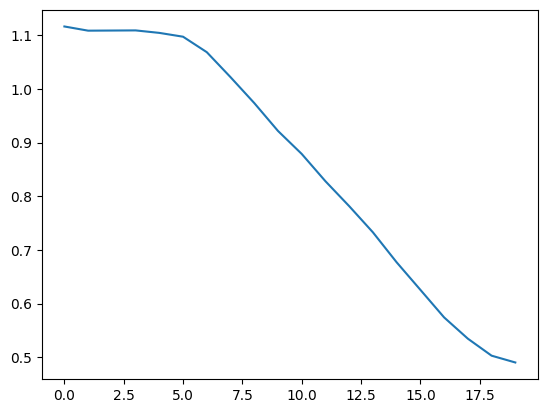

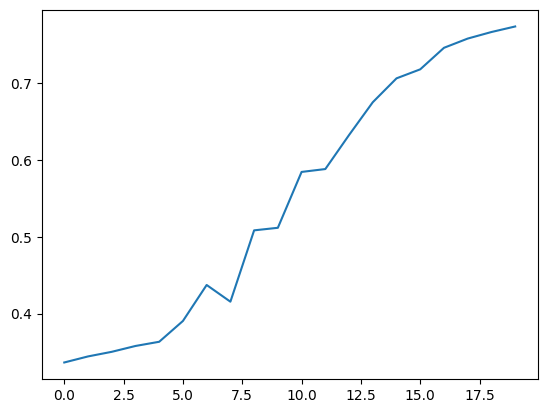

In [48]:
plt.figure()
plt.plot(history['loss'])
plt.figure()
plt.plot(history['accuracy'])

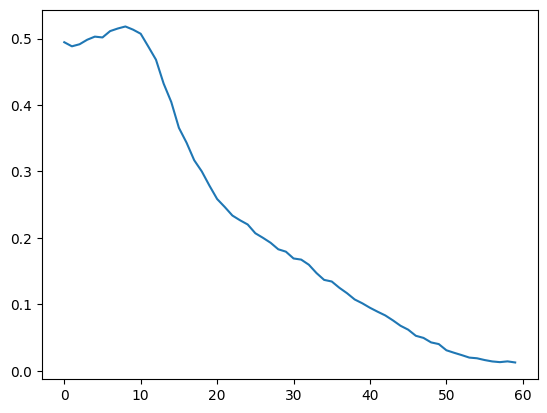

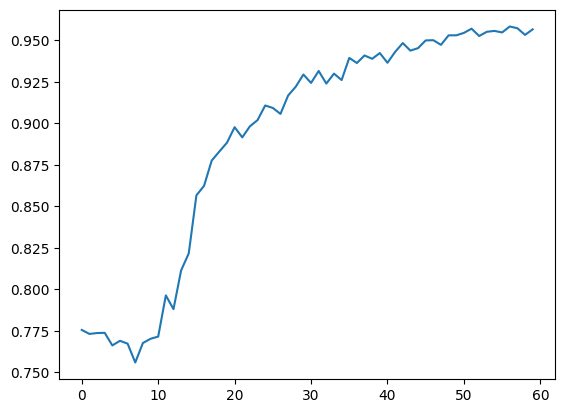

In [63]:
plt.figure()
plt.plot(history['loss'])
plt.figure()
plt.plot(history['accuracy'])

100%|██████████| 30/30 [00:01<00:00, 27.06it/s]


0.96


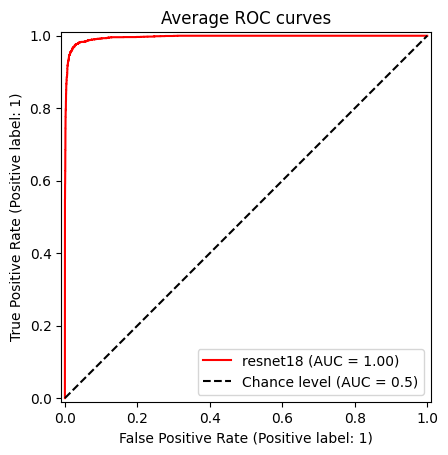

<Figure size 800x800 with 0 Axes>

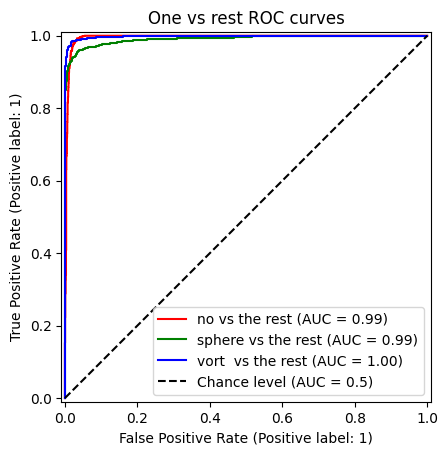

In [73]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def ROC_average(labels_list, outputs_list, preds_list, n_classes=3):
    cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)
    fig, ax = plt.subplots()
    ax.set_title("Average ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    categories ='resnet18' #  0:no 1:sphere 2:vort 
    color='r'
    # plot roc
    ## one hot encode data
    label_binarizer = LabelBinarizer().fit( labels_list)
    onehot = label_binarizer.transform(labels_list)
    plot_chance_level=True
    display = RocCurveDisplay.from_predictions(
        onehot.ravel(),
        outputs_list.ravel(),
        name=categories,
        color=color,
        plot_chance_level=plot_chance_level ,
        ax=ax, 
    )

def ROC_one_vs_rest(labels_list, outputs_list, preds_list, n_classes=3):
    plt.figure(figsize=(4,4), dpi=200)
    categories = ['no', 'sphere', 'vort ']  #  0:no 1:sphere 2:vort  
    color=['r','g','b']
    # plot roc
    ## one hot encode data
    label_binarizer = LabelBinarizer().fit( labels_list)
    onehot = label_binarizer.transform(labels_list)
    fig, ax = plt.subplots()
    ax.set_title("One vs rest ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for class_of_interest in range(n_classes):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        plot_chance_level =False
        ## get roc curve and auroc for each class
        if class_of_interest == n_classes-1:
            plot_chance_level=True
        display = RocCurveDisplay.from_predictions(
            onehot[:, class_id],
            outputs_list[:, class_id],
            name=f"{categories[class_of_interest]} vs the rest",
            color=color[class_of_interest],
            plot_chance_level=plot_chance_level ,
            ax=ax, 
        )
accuracy, labels_list, outputs_list, preds_list=evaluate(model,test_dataloader,return_lists_roc=True)
print(accuracy)
ROC_average(labels_list, outputs_list, preds_list, n_classes=3)
ROC_one_vs_rest(labels_list, outputs_list, preds_list, n_classes=3)